# Higher-performance computing

There are various ways to speed up the execution of code in a Jupyter notebook.  
We will start scratching the surface by looking at

- Numba
- Fortran magic
- Cython

Other ways to increase performance include

- **Numexpr** - a package that speeds up complex array operations (sometimes slow in numpy due to creation of many temporary arrays)
- wrapping C libraries with **ctypes**
- **CFFI** (C Foreign Function Interface for Python)
- **SWIG** (Simplified Wrapper and Interface Generator)
- create a new magic command which compiles C/C++/Fortran code, runs it and returns result!

## Numba

Numpy offers fast vector computations of arrays, but some algorithms can't be vectorized and require explicit loops.  
However, Python loops are slow. `Numba` can speed up Python through a *just-in-time* (JIT) compiler, compiling Python code directly to machine code. 

### Random walk

First without Numba

In [47]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [48]:
def step():
    return 1. if random.random() > .5 else -1.

In [49]:
def walk(n):
    x = np.zeros(n)
    dx = 1. / n
    for i in range(n - 1):
        x_new = x[i] + dx * step()
        if x_new > 5e-3:
            x[i + 1] = 0.
        else:
            x[i + 1] = x_new
    return x

In [50]:
n = 100000
x = walk(n)

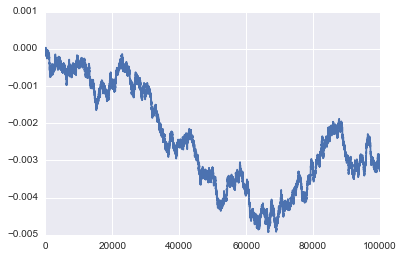

In [51]:
plt.plot(x)

In [52]:
%%timeit
walk(n)

10 loops, best of 3: 117 ms per loop


### <font color="blue"> Demo, *just-in-time* compilation

We import the Numba package, and then add the decorator `@jit` immediately before the function definition

In [53]:
from numba import jit, vectorize, float64

The `nopython=True` argument activates nopython mode, which means that the code is translated directly to machine code, bypassing the CPython interpreter. The nopython mode is faster than python mode, but is more limited and for example lists and dictionaries are not supported. For optimal performance, try to stick with nopython!  

In [54]:
@jit(nopython=True)
def step_numba():
    return 1. if random.random() > .5 else -1.

In [55]:
@jit(nopython=True)
def walk_numba(n):
    x = np.zeros(n)
    dx = 1. / n
    for i in range(n - 1):
        x_new = x[i] + dx * step_numba()
        if x_new > 5e-3:
            x[i + 1] = 0.
        else:
            x[i + 1] = x_new
    return x

`n` is still 10000

In [56]:
%%timeit
walk_numba(n)

The slowest run took 51.35 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 3.29 ms per loop


Quite a decent speedup!

## Mixing in Fortran and C 

* One can compile external functions in Fortran or C, and write python wrappers...
* but it's even simpler to directly use Fortran or Cython, hiding away the wrapping! 

In [57]:
#!pip install cython fortran-magic 

### Fortran

The %%fortran cell magic allows us to write Fortran code into a cell, which gets compiled and imported using `f2py`.


In [58]:
%load_ext fortranmagic

/Users/ktw/.local/lib/python2.7/site-packages/IPython/utils/path.py:265: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module
  warn("get_ipython_cache_dir has moved to the IPython.paths module")


In [59]:
%%fortran?

In [60]:
%%fortran -vvv
# -vvv for verbose output for what is happening under the hood
# One can also give compiler flags, e.g. for OpenMP parallellization
#%%fortran -vvv --f90flags='-fopenmp' --extra='-lgomp' # for OpenMP support
subroutine my_function(x, y, z)
    real, intent(in) :: x(:), y(:)
    real, intent(out) :: z(size(x))
    ! using vector operations  
    z(:) = sin(x(:) + y(:))
end subroutine

Running...
   /Users/ktw/anaconda2/bin/python -m numpy.f2py -m _fortran_magic_67c6d4756b44a5d5ce607e55199e220e -c /Users/ktw/.ipython/fortran/_fortran_magic_67c6d4756b44a5d5ce607e55199e220e.f90
running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "_fortran_magic_67c6d4756b44a5d5ce607e55199e220e" sources
f2py options: []
f2py:> /var/folders/2y/083kpwjs5zlc_3db05ll22180000gn/T/tmpWvTz0_/src.macosx-10.6-x86_64-2.7/_fortran_magic_67c6d4756b44a5d5ce607e55199e220emodule.c
creating /var/folders/2y/083kpwjs5zlc_3db05ll22180000gn/T/tmpWvTz0_/src.macosx-10.6-x86_64-2.7
Reading fortran codes...
	Reading file '/Users/ktw/.ipython/fortran/_fortran_magic_67c6d4756b44a5d5ce607e55199e220e.f90' (format:free)
Post-processing...
	Block: _fortran_magic_67c6d4756b44a5d5ce607e55199e220e
			Block: m

In [61]:
import numpy as np
x = np.random.normal(size=100)
y = np.random.normal(size=100)
z = my_function(x, y)

### Cython

Cython is a superset of Python which supports calling C functions and declaring C types on variables and class attributes.
Cython allows you to
- wrap C/C++ libraries into Python
- optimize Python code by statically compiling with C


We will optimize Python by "cythonizing" it. For wrapping C/C++ libraries, see http://docs.cython.org/en/latest/src/tutorial/

In [62]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [63]:
%%cython?

One can also give compiler flags: `%%cython --compile-args=-fopenmp --link-args=-fopenmp`

### <font color="blue"> Demo: the Mandelbrot fractal </font>

Initialize:

In [64]:
size = 200
iterations = 100

#### Pure python

In [65]:
def mandelbrot_python(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [66]:
%%timeit -n1 -r1 
m = np.zeros((size, size))
mandelbrot_python(m, size, iterations)

1 loop, best of 1: 2.49 s per loop


#### First cython attempt

First just add the cython magic. The `-a` option activates annotation, which shows "how much Python" there's left in the cythonized code (less yellow means less Python and faster execution)

In [67]:
%%cython -a
import numpy as np

def mandelbrot_cython(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [68]:
%%timeit -n1 -r1 
m = np.zeros((size, size), dtype=np.int32)
mandelbrot_cython(m, size, iterations)

1 loop, best of 1: 2.48 s per loop


Small speedup

#### Second attempt

Now add type information, use *memory views* for NumPy arrays, and replace `np.abs()`

In [69]:
%%cython -a
import numpy as np

def mandelbrot_cython(int[:,::1] m, 
                      int size, 
                      int iterations):
    cdef int i, j, n
    cdef complex z, c
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if z.real**2 + z.imag**2 <= 100:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

We have less yellow!

In [70]:
%%timeit -n1 -r1 m = np.zeros((size, size), dtype=np.int32)
mandelbrot_cython(m, size, iterations)

1 loop, best of 1: 3.46 ms per loop


Huge speedup!

### <font color="red"> *Exercise: calculate primes*

1. Take the following Python code which returns prime numbers
2. Run it for `kmax=100` and time it
3. Add the most simple cythonization, using the annotation option
4. Run again and time, compare to pure Python
5. Cythonize it properly! (Hint: replace `p=[]` also). Use annotation, and compare to simple cython
6. Run again and time, compare to pure Python and simple Cython
6. Try just-in-time compilation using `Numba` and compare to Cython

In [71]:
def primes(kmax):  
    p = []
    result = []  
    if kmax > 1000:
        kmax = 1000
    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i = i + 1
        if i == k:
            p.append(n)
            k = k + 1
            result.append(n)
        n = n + 1
    return result

### <font color="green"> *Solution: calculate primes*

In [72]:
%%timeit
p = primes(100)

100 loops, best of 3: 2.26 ms per loop


Start with simplest cython

In [73]:
%%cython
def primes_simplecython(kmax):  
    p = []
    result = []  
    if kmax > 1000:
        kmax = 1000
    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i = i + 1
        if i == k:
            p.append(n)
            k = k + 1
            result.append(n)
        n = n + 1
    return result

In [74]:
%%timeit
p = primes_simplecython(100)

1000 loops, best of 3: 419 µs per loop


Now for proper cythonization. Add annotation (`-a`) if you want!

In [75]:
%%cython?

In [76]:
%%cython
def primes_cython(int kmax):  # The argument will be converted to int or raise a TypeError.
    cdef int n, k, i  # These variables are declared with C types.
    cdef int p[1000]  # Another C type
    result = []  # A Python type
    if kmax > 1000:
        kmax = 1000
    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i = i + 1
        if i == k:
            p[k] = n
            k = k + 1
            result.append(n)
        n = n + 1
    return result

In [ ]:
%%timeit
p = primes_cython(100)

Another factor 10 in speedup

Finally, let's compare with just-in-time compilation with numba

In [78]:
@jit
def primes_jit(kmax):  
    p = []
    result = []  
    if kmax > 1000:
        kmax = 1000
    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i = i + 1
        if i == k:
            p.append(n)
            k = k + 1
            result.append(n)
        n = n + 1
    return result

In [79]:
%%timeit
p = primes_jit(100)


The slowest run took 1543.30 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 87.7 µs per loop


Almost as fast as cython in this case (factor ~2 slower)

Notice that the slowest run took much much longer than the fastest.  
`cache=True` stores the compiled function in a file and avoids re-compilation on re-running


In [80]:
@jit(cache=True)
def primes_jit2(kmax):  
    p = []
    result = []  
    if kmax > 1000:
        kmax = 1000
    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i = i + 1
        if i == k:
            p.append(n)
            k = k + 1
            result.append(n)
        n = n + 1
    return result

In [82]:
%%timeit
p = primes_jit2(100)

10000 loops, best of 3: 66.3 µs per loop


Now the slowest run to "only" 240 times longer than fastest